In [1]:
!pip install tqdm

In [2]:
# 1) Rutas y pathing del proyecto (este notebook vive en notebooks/)
import sys, os
from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if lib_path not in sys.path:
    sys.path.insert(0, lib_path)
print("Project root added to sys.path:", lib_path)

Project root added to sys.path: D:\FakeVoiceFinder


In [3]:
from fakevoicefinder.inference import InferenceRunner, FakeProbabilityGauge

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from fakevoicefinder.inference import InferenceRunner

# ---------------------------
# PATHS
# ---------------------------
real_folder = "real_sample"
fake_folder = "fake_sample"
models_folder = "models"

csv_output = "inference_results_v9.csv"

device = None


# ---------------------------
# TRANSFORM CONFIGURATIONS
# ---------------------------
transform_dict = {
    "mel": {"sample_rate":16000, "clip_seconds":4.0, "image_size":224, "n_mels":68, "n_fft":2048, "hop_length":512},
    "log": {"sample_rate":16000, "clip_seconds":4.0, "image_size":224, "n_fft":2048, "hop_length":256},
    "dwt": {"sample_rate":16000, "clip_seconds":4.0, "image_size":224, "wavelet":"db6", "level":5, "mode":"symmetric"},
    "cqt": {"sample_rate":16000, "clip_seconds":4.0, "image_size":224, "hop_length":256,
            "n_bins":96, "bins_per_octave":24, "scale":True},
}

# ---------------------------
# PARSE MODEL NAMES
# ---------------------------
def parse_model_filename(fname: str):
    """
    Example filenames:
    alexnet_scratch_cqt_seed23_epoch010_acc0.94.pt
    squeezenet1_0_scratch_dwt_seed23_epoch001_acc0.67.pt
    vgg16_pretrain_mel_seed23_epoch004_acc0.99.pt
    """
    base = os.path.splitext(fname)[0]
    parts = base.split("_")

    # model name can include numbers e.g., "squeezenet1_0"
    # strategy: model name = everything until we hit "scratch" or "pretrain"
    variant_idx = None
    for i, p in enumerate(parts):
        if p in ("scratch", "pretrain"):
            variant_idx = i
            break

    if variant_idx is None:
        return None, None, None

    model_name = "_".join(parts[:variant_idx])
    variant = parts[variant_idx]
    train_transform = parts[variant_idx + 1]  # mel/log/dwt/cqt

    return model_name, variant, train_transform


# ---------------------------
# FILENAME PARSER FOR AUDIO
# ---------------------------
def parse_audio_filename(fname: str):
    base = os.path.splitext(fname)[0]
    parts = base.split("_")
    label = parts[0] if len(parts) > 0 else ""
    audio_id = parts[1] if len(parts) > 1 else ""
    tool = parts[2] if len(parts) > 2 else ""
    return label, audio_id, tool


# ---------------------------
# COLLECT AUDIO FILES
# ---------------------------
valid_exts = {".wav", ".mp3", ".flac", ".m4a", ".ogg"}
audio_files = []

for folder in [real_folder, fake_folder]:
    p = Path(folder)
    if p.exists():
        for f in p.iterdir():
            if f.suffix.lower() in valid_exts:
                audio_files.append(str(f.resolve()))


# ---------------------------
# COLLECT MODELS + METADATA
# ---------------------------
models_info = []
pmodels = Path(models_folder)
for f in pmodels.iterdir():
    if f.suffix == ".pt":
        m_name, m_variant, m_train_t = parse_model_filename(f.name)
        if m_name is not None:
            models_info.append({
                "path": str(f.resolve()),
                "file": f.name,
                "model_name": m_name,
                "variant": m_variant,
                "train_transform": m_train_t
            })


# ---------------------------
# INFERENCE LOOP (FILTERED)
# ---------------------------
rows = []

for transform_name, transform_params in transform_dict.items():

    # Only use models trained with the same transform
    models_filtered = [
        m for m in models_info
        if m["train_transform"] == transform_name
    ]

    print(f"\n=== Transform: {transform_name} — Using {len(models_filtered)} matching models ===")

    for model in tqdm(models_filtered, desc=f"Models ({transform_name})", ncols=100):

        runner = InferenceRunner(
            model_path=model["path"],
            transform=transform_name,
            transform_params=transform_params,
            device=device,
        )

        for audio_path in audio_files:
            fname = os.path.basename(audio_path)
            label, audio_id, tool = parse_audio_filename(fname)

            try:
                out = runner.predict(audio_path)
            except:
                continue

            pred_label = out.get("pred_label")

            rows.append({
                "audio": fname,
                "tool": tool,
                "label": label,
                "model_name": model["model_name"],
                "variant": model["variant"],
                "train_transform": model["train_transform"],
                "infer_transform": transform_name,
                "real_score": out.get("real"),
                "fake_score": out.get("fake"),
                "pred_label": pred_label,
                "confidence": out.get("confidence"),
                "correct": 1 if pred_label == label else 0,
            })


# ---------------------------
# SAVE RESULTS
# ---------------------------
df = pd.DataFrame(rows)
df.to_csv(csv_output, index=False)
print("Saved:", csv_output)
print(df.head())







=== Transform: mel — Using 32 matching models ===


Models (mel): 100%|█████████████████████████████████████████████████| 32/32 [01:13<00:00,  2.30s/it]



=== Transform: log — Using 32 matching models ===


Models (log): 100%|█████████████████████████████████████████████████| 32/32 [01:39<00:00,  3.12s/it]



=== Transform: dwt — Using 32 matching models ===


Models (dwt): 100%|█████████████████████████████████████████████████| 32/32 [00:59<00:00,  1.85s/it]



=== Transform: cqt — Using 32 matching models ===


Models (cqt): 100%|█████████████████████████████████████████████████| 32/32 [03:19<00:00,  6.24s/it]

Saved: inference_results_v9.csv
                     audio         tool label model_name   variant  \
0  real_10_commonvoice.wav  commonvoice  real    alexnet  pretrain   
1  real_11_commonvoice.wav  commonvoice  real    alexnet  pretrain   
2  real_12_commonvoice.wav  commonvoice  real    alexnet  pretrain   
3  real_13_commonvoice.wav  commonvoice  real    alexnet  pretrain   
4  real_14_commonvoice.wav  commonvoice  real    alexnet  pretrain   

  train_transform infer_transform  real_score  fake_score pred_label  \
0             mel             mel       86.25       13.75       real   
1             mel             mel       99.08        0.92       real   
2             mel             mel       94.78        5.22       real   
3             mel             mel       98.24        1.76       real   
4             mel             mel       85.08       14.92       real   

   confidence  correct  
0       86.25        1  
1       99.08        1  
2       94.78        1  
3       98.24 

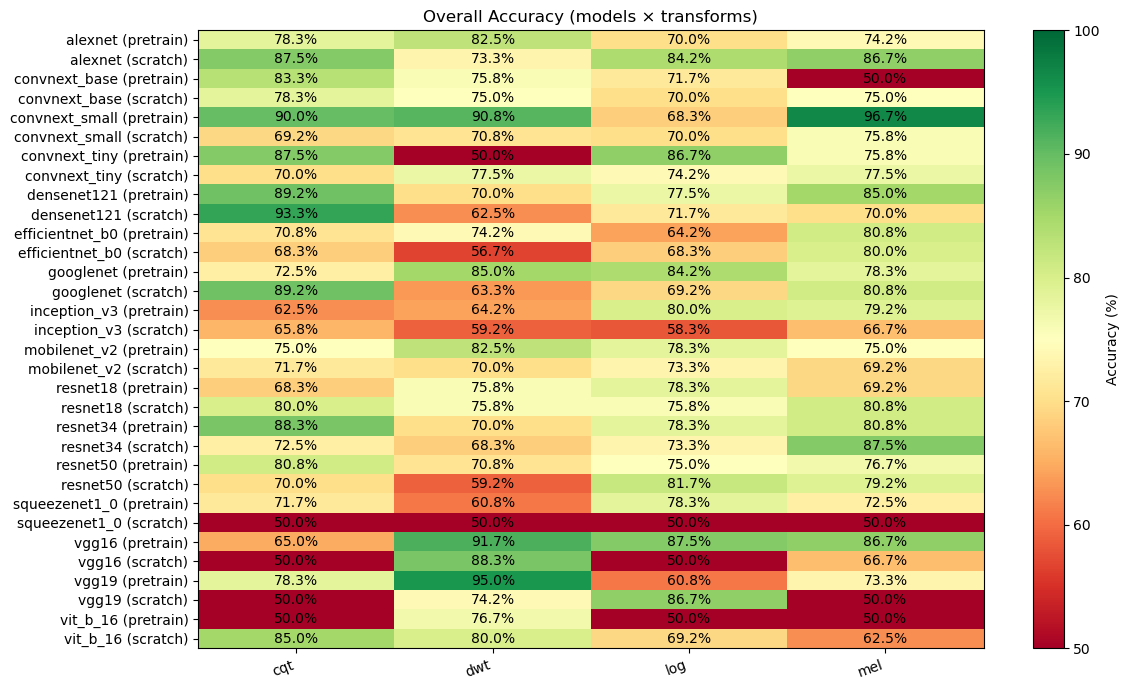

Heatmap saved: heatmap_overall.png


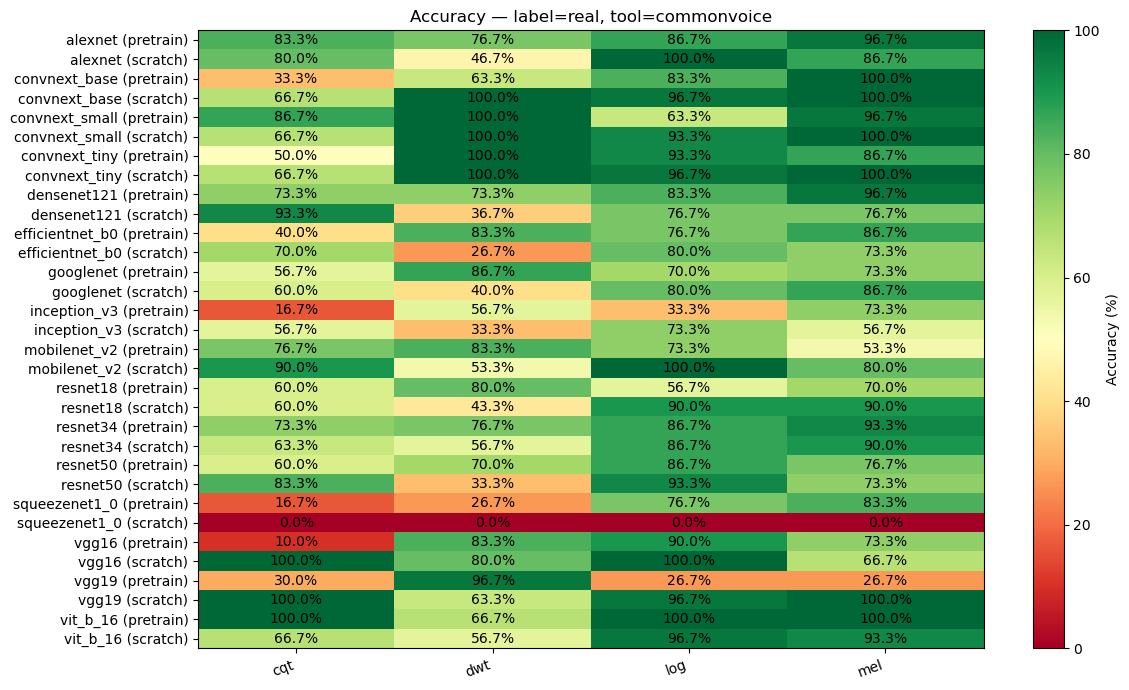

Heatmap saved: heatmap_real_commonvoice.png


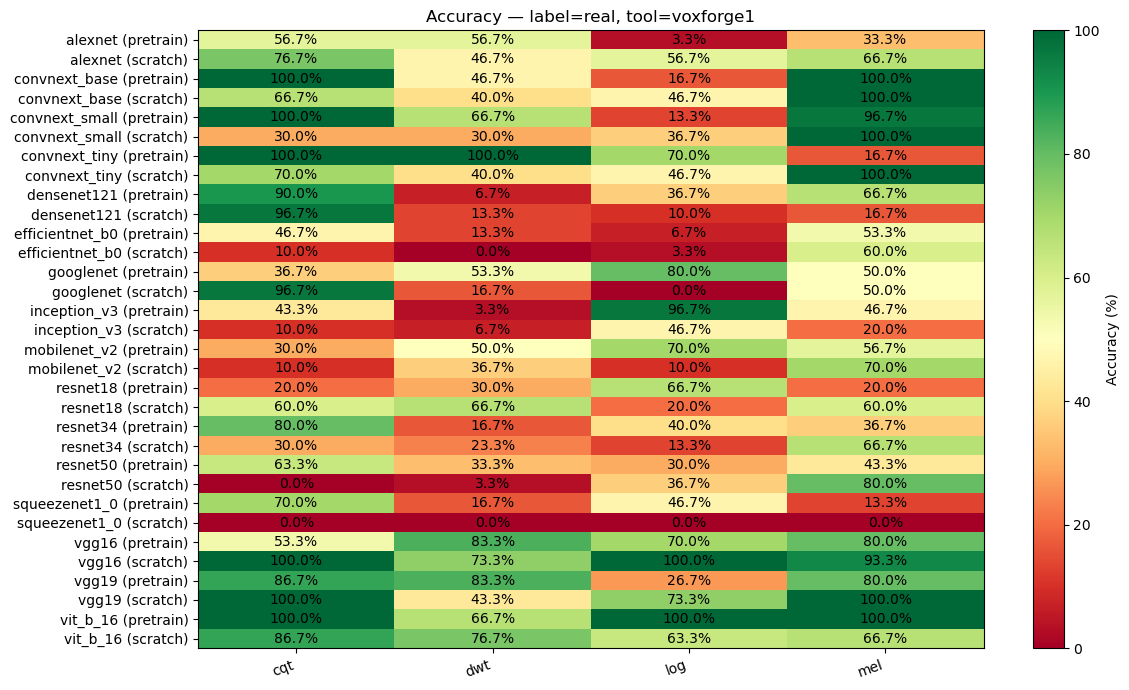

Heatmap saved: heatmap_real_voxforge1.png


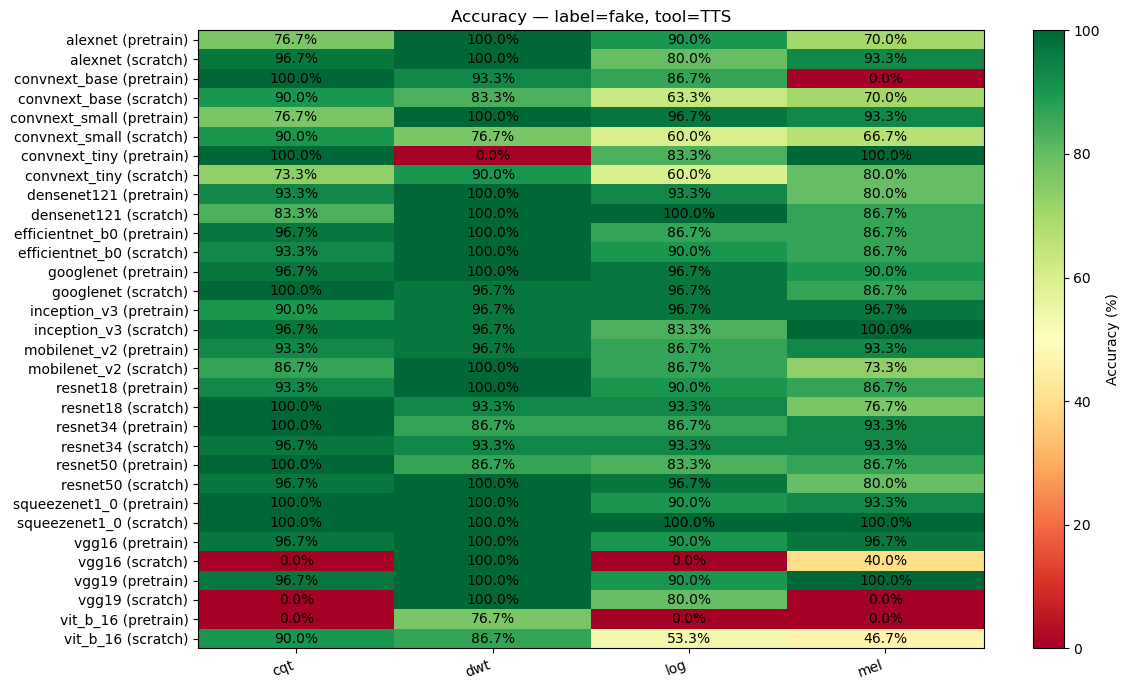

Heatmap saved: heatmap_fake_TTS.png


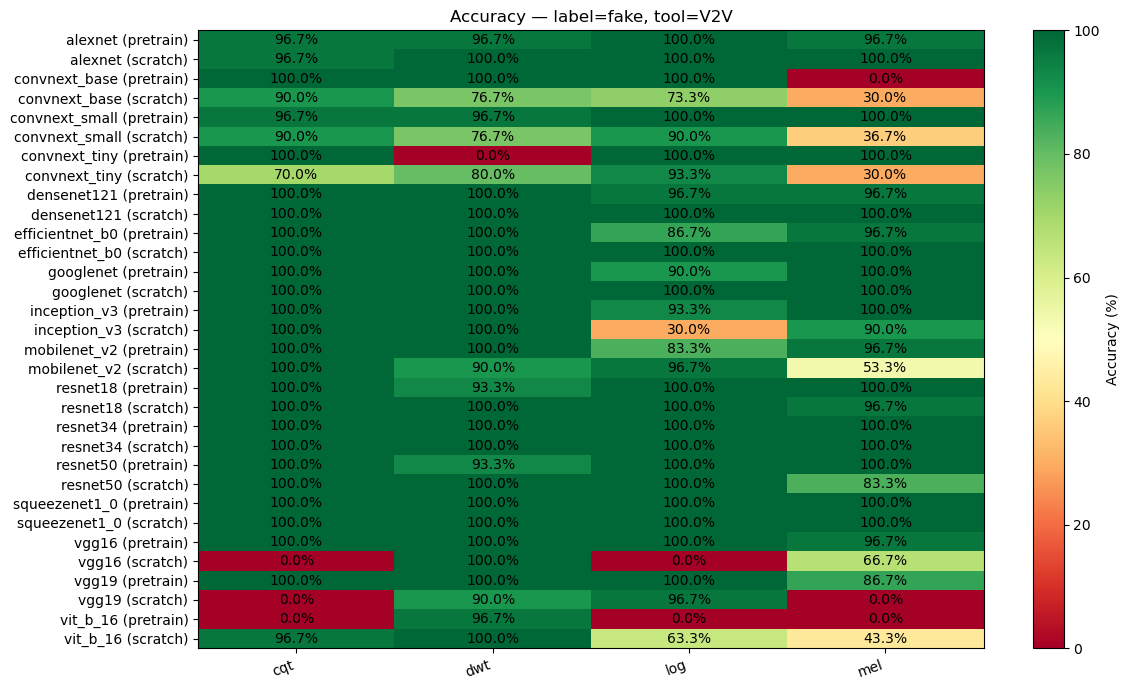

Heatmap saved: heatmap_fake_V2V.png


In [9]:
# --------------------------------------------------------------------
#                          HEATMAP PLOTTING
# --------------------------------------------------------------------
def plot_heatmap(df: pd.DataFrame, title: str, outname: str):
    pivot = df.pivot_table(
        index=df["model_name"] + " (" + df["variant"] + ")",
        columns="train_transform",
        values="correct",
        aggfunc="mean"
    ) * 100

    A = pivot.to_numpy(dtype=float)

    plt.figure(figsize=(12, 7))
    im = plt.imshow(
        A,
        aspect="auto",
        interpolation="nearest",
        cmap="RdYlGn",
        vmin=np.nanmin(A),
        vmax=100.0,
    )
    plt.colorbar(im, label="Accuracy (%)")

    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=20, ha="right")

    plt.title(title)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            value = A[i, j]
            txt = "—" if np.isnan(value) else f"{value:.1f}%"
            plt.text(j, i, txt, ha="center", va="center", fontsize=10, color="black")

    plt.tight_layout()
    plt.savefig(outname, dpi=150)
    plt.show()
    print("Heatmap saved:", outname)


# ---------------------------
# GLOBAL HEATMAP
# ---------------------------

df_final = df.copy()
plot_heatmap(
    df_final,
    title="Overall Accuracy (models × transforms)",
    outname="heatmap_overall.png"
)

# ---------------------------
# HEATMAP PER (label, tool)
# ---------------------------
unique_labels = df_final["label"].unique()
unique_tools = df_final["tool"].unique()

for lab in unique_labels:
    for tl in unique_tools:
        subset = df_final[(df_final["label"] == lab) & (df_final["tool"] == tl)]
        if len(subset) == 0:
            continue

        fig_name = f"heatmap_{lab}_{tl}.png"
        title = f"Accuracy — label={lab}, tool={tl}"

        plot_heatmap(subset, title, fig_name)